# Gibbs sampling

Gibbs sampling consists in replacing a simulation of $d$-dimensional random variables with $d$ independent $1$-dimensional random variables. This requires the knowledge of the marginal distributions of each component given all the others, which isn't necessarily easy. However, in the case of Gaussian distributions, this is quite straightforward. Indeed we have:

$ \pi(x \mid x_{-i}) \sim N \left( - V_{ii}^{-1} \sum_{j \not = i} V_{ij}x_j, V_{ii}^{-1} \right).$

We can write the sum a bit differently:

$ - V_{ii}^{-1} \sum_{j \not = i} V_{ij}x_j = - V_{ii}^{-1} \left( \sum_{j} V_{ij}x_j - V_{ii} x_i \right) = - V_{ii}^{-1} (Vx)_i + x_i.$

In Gibbs sampling, we simulate the new coordinate for $x_i$ according to the distribution above, which means we simply have to add to the former $x_i$ a Gaussian $N \left( - V_{ii}^{-1} (Vx)_i, V_{ii}^{-1} \right)$

We start by some imports.

In [1]:
# For mybinder, uncomment
#%%bash
#pip install numpy matplotlib ipywidgets

In [2]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
% matplotlib inline
% matplotlib notebook
import ipywidgets as widgets
from IPython.display import display

## Simple example
We first take an example in two dimensions, which will show the steps that takes the Gibbs sampler.

In [3]:
example_V = np.array([[5,4.5],[4.5,5]])
display(example_V)
display(np.linalg.inv(example_V))

array([[ 5. ,  4.5],
       [ 4.5,  5. ]])

array([[ 1.05263158, -0.94736842],
       [-0.94736842,  1.05263158]])

We display here the density of the distribution, up to a multiplicative constant (the Gibbs sampling methid doesn't require its knowledge).

In [4]:
def pi(x,mean=np.zeros(2),V=example_V):
    return np.exp(-.5*np.dot(x,np.dot(V,x)))

<IPython.core.display.Javascript object>


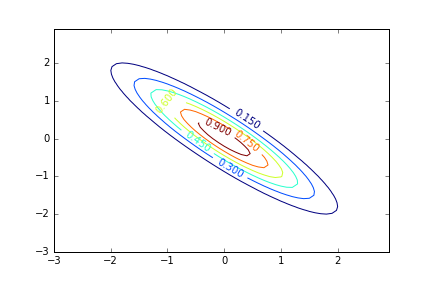

In [5]:
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi(np.array([X[i,j],Y[i,j]]),V=example_V) for j in range(len(X[0]))] for i in range(len(X))])
fig1 = plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10);

In [6]:
def gibbsSampler(n,x0=np.zeros(2),V=example_V):
    d = len(x0)
    trajectory = [x0]
    additional_steps = []
    x = np.copy(x0)
    for k in range(1,n):
        for i in range(d):
            Vii_inv = 1./V[i,i]
            mean_i = - Vii_inv*np.dot(V[i,:],x)
            x[i] += np.random.normal(mean_i,Vii_inv)
            if i == d-1:
                trajectory += [np.copy(x)]
            else:
                additional_steps += [np.copy(x)]
    return np.array(trajectory), np.array(additional_steps)

The program above privides the Gibbs sample and the intermediary steps used for its computation.

<IPython.core.display.Javascript object>


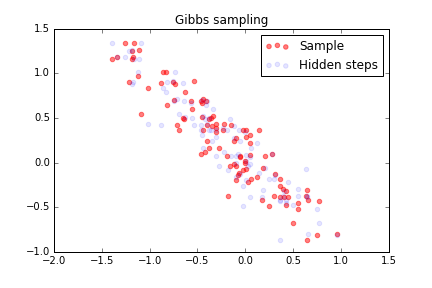

In [7]:
fig2 = plt.figure()
sample, steps = gibbsSampler(100)
plt.scatter(sample[:,0],sample[:,1],color='red',label='Sample',alpha=.5)
plt.scatter(steps[:,0],steps[:,1],color='blue',label='Hidden steps',alpha=.1)
plt.legend(loc='best')
plt.title('Gibbs sampling');

Let's see how this happens step by step. We use for this ipywidgets:

<IPython.core.display.Javascript object>


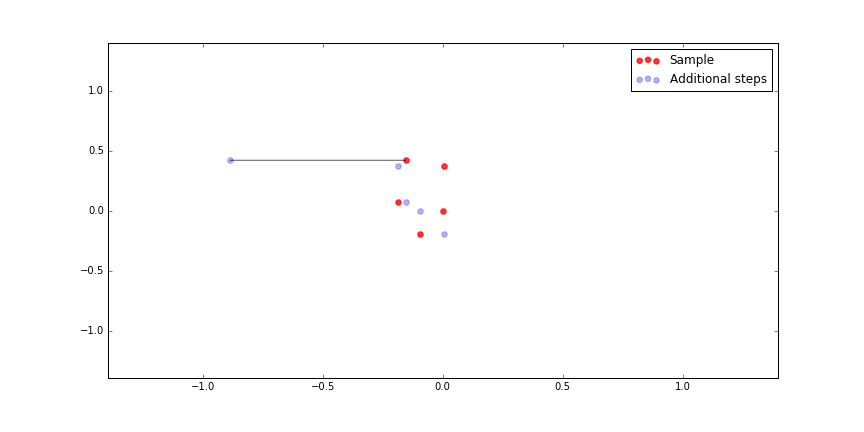

IntSlider(value=0)

Button(description=u'Advance', style=ButtonStyle())

In [8]:
def start_scatter_first(sample,steps):
    fig = plt.figure(figsize=(12,6))
    lim = np.max(np.abs(np.append(sample,steps)))
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    plt.scatter([],[],alpha=.8,label='Sample',color='red',s=30)
    plt.scatter([],[],alpha=.3,label='Additional steps',color='blue',s=30)
    plt.legend(loc='best')
    plt.show()
    return fig

fig3 = start_scatter_first(sample,steps)

def update_scatter_first(n,sample,steps,figure):
    d = len(sample[0])
    sm = sample[:((1+n)/d)]
    st = steps[:(n-(1+n)/d)]
    plt.figure(figure.number)
    pc1, pc2 = figure.axes[0].collections
    pc1.set_offsets(sm)
    pc2.set_offsets(st)
    
def draw_arrow(n,sample,steps,figure):
    d = len(sample[0])
    sm = sample[:((1+n)/d)]
    st = steps[:(n-(1+n)/d)]
    plt.figure(figure.number)
    last_in_sm = ((1+n)%d == 0)
    before_last_in_sm = (n%d == 0)
    w = .000001
    alph=.5
    figure.axes[0].artists = []
    if last_in_sm:
        plt.arrow(st[-1][0],st[-1][1],sm[-1][0]-st[-1][0],sm[-1][1]-st[-1][1],width=w,alpha=alph)
    elif before_last_in_sm:
        plt.arrow(sm[-1][0],sm[-1][1],st[-1][0]-sm[-1][0],st[-1][1]-sm[-1][1],width=w,alpha=alph)
    else:
        plt.arrow(st[-2][0],st[-2][1],st[-1][0]-st[-2][0],st[-1][1]-st[-2][1],width=w,alpha=alph)
    
    
def update_length_first(value):
    update_scatter_first(n=value['new'],sample=sample,steps=steps,figure=fig3)
    if value['new']>1:
        draw_arrow(n=value['new'],sample=sample,steps=steps,figure=fig3)
    
slider_first = widgets.IntSlider(min=0,max=100,step=1)
display(slider_first)
slider_first.observe(update_length_first,names='value')
def incrementSlider(b):
    slider_first.value += 1
advanceButton = widgets.Button(value=False,description='Advance')
display(advanceButton)
advanceButton.on_click(incrementSlider)

## Gaussian Graphical Models

As said above, the Gibbs sampling method replaces the simulation of $d$-dimensional random variables with $d$ simulations of $1$-dimenional random variables. Let us show more precisely the advantage of the latter over the former.

A typical procedure to simulate a $d$ dimensional Gaussian variable $N(0,V)$ consists in first factorizing $V = O^\top O$. Then if $Y \sim N(0,Id)$, $X \sim N(0,V)$. The simulatin of $Y$ consists in simulating $d$ independent Gaussian $1$-dimensional variables. The hard part is the factorization, which necessitates $O(d^3)$ steps.

In the Gibbs sampling method, we simply read the variance of each Gaussian we wish to simulate, but we need to compute its mean. The mean is obtained through a dot product which carries a computational cost of $O(d)$. This being done for $d$ Gaussians at each step, the steps have a computational cost of $O(d^2)$.

This quadratic cost is sometimes still to high. However, it can be further restrained through the assumption of sparsity of the matrix $V$. Indeed, if every lign has at most $s<d$ non-zero entries, we can reduce the cost to $O(ds)$ multiplications. This bring us to the notion of Gaussian Graphical Models

### Conditional independence in Gaussian Variables

The inverse of the covariance matrix, called the precision matrix, can be read in a very interesting way. Assume $X \sim N(0,V^{-1})$ is a Gaussian random variable, where we denote by $X_1$ the first $p$ coponents and $X_2$ the remainder. Write

$ V = \begin{pmatrix} V_{11} & V_{12} \\ V_{21} & V_{22} \end{pmatrix}$

Then the variance of $X_1$ given $X_2$ is $V_{11}$.

As a result, two Gaussian random variables $X_i$ and $X_j$ are independent conditionally to the rest if and only if their corresponding precision matrix entry $V_{ij} = 0$.

### A graphical notation

We define a graph where each node represents a random variable and there is an edge between node $i$ and $j$ if the pair is conditionally dependent. Then for Gaussian vectors, the non-zero entries of $V$ are the edges of the graph. The matrix $V$, without is diagonal, can be seen as an adjacency matrix.

In [9]:
import networkx as nx

In [10]:
v_10 = np.identity(10)
for i in range(9):
    v_10[i,i+1] = .3
    v_10[i+1,i] = .3
v_10[0,9] = .3
v_10[9,0] = .3
display(v_10)
np.all(np.linalg.eigvals(v_10) > 0)

array([[ 1. ,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.3],
       [ 0.3,  1. ,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.3,  1. ,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.3,  1. ,  0.3,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.3,  1. ,  0.3,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.3,  1. ,  0.3,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.3,  1. ,  0.3,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.3,  1. ,  0.3,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.3,  1. ,  0.3],
       [ 0.3,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.3,  1. ]])

True

<IPython.core.display.Javascript object>


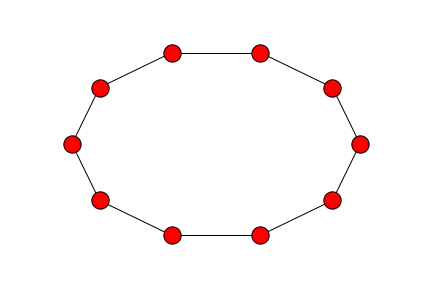

In [11]:
g_10 = nx.from_numpy_array(v_10-np.diag(np.diag(v_10)))
plt.figure()
nx.draw_circular(g_10)

Even in dimension $10$, the computation speed increases will be negligible, if any. However if $s<10$ and $d > 10^5$, it would become more than noticeable.

In [12]:
from scipy import sparse

In [13]:
diag_V = np.diag(v_10)

In [14]:
sparse_V = sparse.csr_matrix(v_10)
sparse_V

<10x10 sparse matrix of type '<type 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [15]:
def gibbsSamplerSparse(n,x0=np.zeros(2),V=sparse_V,diagV=diag_V):
    d = len(x0)
    trajectory = [x0]
    additional_steps = []
    x = np.copy(x0)
    for k in range(1,n):
        for i in range(d):
            Vii_inv = 1./diagV[i]
            mean_i = - Vii_inv*V[i].dot(x)
            x[i] += np.random.normal(mean_i,Vii_inv)
            if i == d-1:
                trajectory += [np.copy(x)]
            else:
                additional_steps += [np.copy(x)]
    return np.array(trajectory), np.array(additional_steps)

In [16]:
traj_10 = gibbsSamplerSparse(10,x0=np.zeros(10))

<IPython.core.display.Javascript object>


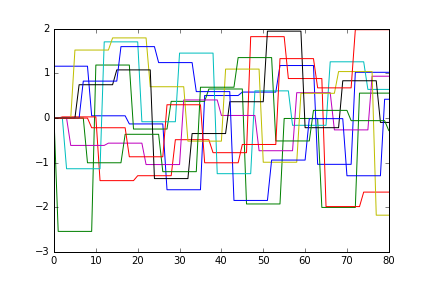

In [18]:
plt.figure()
plt.plot(traj_10[1]);

The figure above shows the values of the coordinates of the additional steps (the main points that are the true result of the Gibbs sampler are omitted). We observe that the corrdinates stay constant for periods of around $10$ - which illustrates again that at each hidden step, only one coordinate changes.

<IPython.core.display.Javascript object>


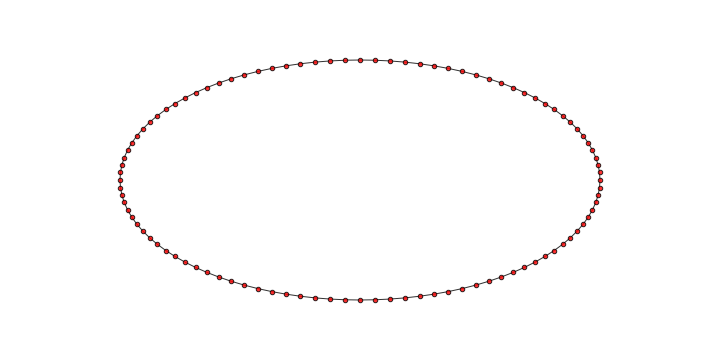

True

In [20]:
v_100 = np.identity(100)
for i in range(99):
    v_100[i,i+1] = .3
    v_100[i+1,i] = .3
v_100[0,99] = .3
v_100[99,0] = .3
plt.figure(figsize=(10,5))
nx.draw_circular(nx.from_numpy_array(v_100),node_size=20,alpha=.8,edge_width=2.)
np.all(np.linalg.eigvals(v_100) > 0)

In [21]:
diag_V_100 = np.diag(v_100)
sparse_V_100 = sparse.csr_matrix(v_100)

In [22]:
traj_100 = gibbsSamplerSparse(100,x0=np.zeros(100),V=sparse_V_100,diagV=diag_V_100)

In [23]:
norms_100 = np.linalg.norm(traj_100[0],axis=1)

<IPython.core.display.Javascript object>


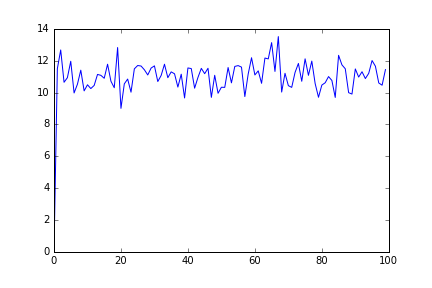

In [24]:
plt.figure()
plt.plot(norms_100);

# What we have learned

The Gibbs sampler consists in successively replacing each coordinate according to distributions that keep the chain in the stationary distribution.

* The method replaces the simulation of $d$-dimensional variables by $d$ simulations of $1$-dimensional variables;

* This introduces for each major step $d$ "hidden steps", for which only $1$ coordinate changed compared to the step before.

In terms of modelling:

* The method requires the knowledge of marginal distributions given the rest of the vector, as well as of an efficient method for simulating that distribution. This works well with Gaussian variables;

* The computation of the conditional marginal distribution is easier when there is dependence only among a restricted number of variables - for instance for Graphical models (see the Ising model);

* The two points above make the method perfectly adapted for Gaussian Graphical Models.